In [1]:
import pandas as pd
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel, LdaModel
import ast
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords

# INITIALIZATION
import os
directory = os.path.realpath(os.path.join(os.getcwd(),".."))
os.chdir(directory)
print(directory)

F:\Documents\Projects\McGill\McGill-INSY-669-GroupProject


In [2]:
lemmatized_text_data = pd.read_csv(os.path.join(directory, 'data', 'Amazon', 'Amazon_comments_processed.csv'))
lemmatized_text_data = lemmatized_text_data.iloc[:, 1:]
lemmatized_text_data

Pros  \
0     ['documentation', 'amazon', 'super', 'importan...   
1                        ['4', 'day', 'shifts', 'nice']   
2     ['great', 'work', 'balance', 'great', 'environ...   
3     ['good', 'benefit', 'flexible', 'time', 'shift...   
4     ['fast', 'paced', 'start-up', 'culture', 'bene...   
...                                                 ...   
9995  ['amazon', 'wonderful', 'search', 'site', 'fin...   
9996  ['great', 'company', 'easy', 'find', 'area', '...   
9997  ['great', 'teamwork', 'great', 'work', 'enviro...   
9998  ['become', 'excellent', 'problem', 'solver', '...   
9999                                 ['pro', 'company']   

                                                   Cons                  id  \
0     ['need', 'understand', 'job', 'need', 'improve...  empReview_73247758   
1     ['long', 'hour', 'shift', 'make', 'feel', 'tire']  empReview_73187609   
2                    ['workload', 'heavy', 'sometimes']  empReview_73188818   
3     ['good', 'organization', 'work', 'well', 'car'...  empReview_73190433   
4     ['compensation', 'growth', 'prospect', 'develo...  empReview_73197210   
...                                                 ...                 ...   
9995   ['interview', 'process', 'long', 'worth', 'end']  empReview_71536795   
9996                         ['get', 'unlucky', 'team']  empReview_71537065   
9997                          ['little', 'far', 'home']  empReview_71539933   
9998  ['cut-throat', 'management', 'toxic', 'culture...  empReview_71882994   
9999              ['poor', 'pay', 'poor', 'management']  empReview_72354621   

      Stars Company_name Recommend CEO_approval Business_outlook  \
0       5.0       Amazon  positive      neutral          neutral   
1       5.0       Amazon   neutral      neutral          neutral   
2       5.0       Amazon  positive     positive         positive   
3       5.0       Amazon  positive     positive         positive   
4       4.0       Amazon  positive     negative         negative   
...     ...          ...       ...          ...              ...   
9995    5.0       Amazon  positive     positive         positive   
9996    5.0       Amazon   neutral      neutral          neutral   
9997    5.0       Amazon  positive     positive         positive   
9998    2.0       Amazon  negative     negative         negative   
9999    1.0       Amazon   neutral      neutral          neutral   

                  Location        Date     Employee_type Employee_sen  
0              Toronto, ON  2023-02-02  current employee       <1 yrs  
1              Toronto, ON  2023-01-31   former employee       <1 yrs  
2               Amazon, SK  2023-01-31   former employee      1-3 yrs  
3                      NaN  2023-01-31   former employee          NaN  
4            Vancouver, BC  2023-01-31  current employee      3-5 yrs  
...                    ...         ...               ...          ...  
9995                   NaN  2022-12-01  current employee       <1 yrs  
9996                   NaN  2022-12-01  current employee          NaN  
9997  Querétaro, Querétaro  2022-12-01  current employee       <1 yrs  
9998             Diego, CA  2022-12-15   former employee      1-3 yrs  
9999                   NaN  2023-01-05   former employee          NaN  

[10000 rows x 12 columns]

In [3]:
# df = lemmatized_text_data[['id', 'Employee_seniority', 'Pros', 'Cons']]
# df['current_employee'] = df['Employee_seniority'].apply(lambda x: 'current' in x).astype(int)
df = lemmatized_text_data[['id', 'Employee_type', 'Pros', 'Cons']]
df.columns = ['id', 'current_employee', 'Pros', 'Cons']
df['Pros'] = df['Pros'].apply(ast.literal_eval)
df['Cons'] = df['Cons'].apply(ast.literal_eval)
df

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\640768273.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Pros'] = df['Pros'].apply(ast.literal_eval)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\640768273.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Cons'] = df['Cons'].apply(ast.literal_eval)


id  current_employee  \
0     empReview_73247758  current employee   
1     empReview_73187609   former employee   
2     empReview_73188818   former employee   
3     empReview_73190433   former employee   
4     empReview_73197210  current employee   
...                  ...               ...   
9995  empReview_71536795  current employee   
9996  empReview_71537065  current employee   
9997  empReview_71539933  current employee   
9998  empReview_71882994   former employee   
9999  empReview_72354621   former employee   

                                                   Pros  \
0     [documentation, amazon, super, important, poin...   
1                                [4, day, shifts, nice]   
2     [great, work, balance, great, environment, loc...   
3     [good, benefit, flexible, time, shift, take, c...   
4             [fast, paced, start-up, culture, benefit]   
...                                                 ...   
9995  [amazon, wonderful, search, site, find, anythi...   
9996           [great, company, easy, find, area, like]   
9997  [great, teamwork, great, work, environment, pe...   
9998  [become, excellent, problem, solver, use, data...   
9999                                     [pro, company]   

                                                   Cons  
0     [need, understand, job, need, improve, good, d...  
1                 [long, hour, shift, make, feel, tire]  
2                          [workload, heavy, sometimes]  
3     [good, organization, work, well, car, parking,...  
4     [compensation, growth, prospect, development, ...  
...                                                 ...  
9995             [interview, process, long, worth, end]  
9996                               [get, unlucky, team]  
9997                                [little, far, home]  
9998  [cut-throat, management, toxic, culture, unnec...  
9999                      [poor, pay, poor, management]  

[10000 rows x 4 columns]

## Pros:

In [4]:
# Prepare Dictionary
data_ready_pros = df['Pros'].tolist()
id2word = corpora.Dictionary(data_ready_pros)
corpus_pros = [id2word.doc2bow(text) for text in data_ready_pros]

In [5]:
# Building model
num_topics = [i+1 for i in range(8)]
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = gensim.models.ldamodel.LdaModel(corpus=corpus_pros,
                                                    id2word=id2word,
                                                    num_topics=i,
                                                    update_every=1,
                                                    chunksize=10,
                                                    passes=20,
                                                    alpha='asymmetric',
                                                    random_state=100)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|██████████| 8/8 [05:52<00:00, 44.12s/it]


In [6]:
coherences = []
for i in tqdm(num_topics):
    coherences.append(gensim.models.CoherenceModel(model=LDA_models[i], texts=data_ready_pros, dictionary=id2word, coherence='c_v').get_coherence())

100%|██████████| 8/8 [00:54<00:00,  6.82s/it]


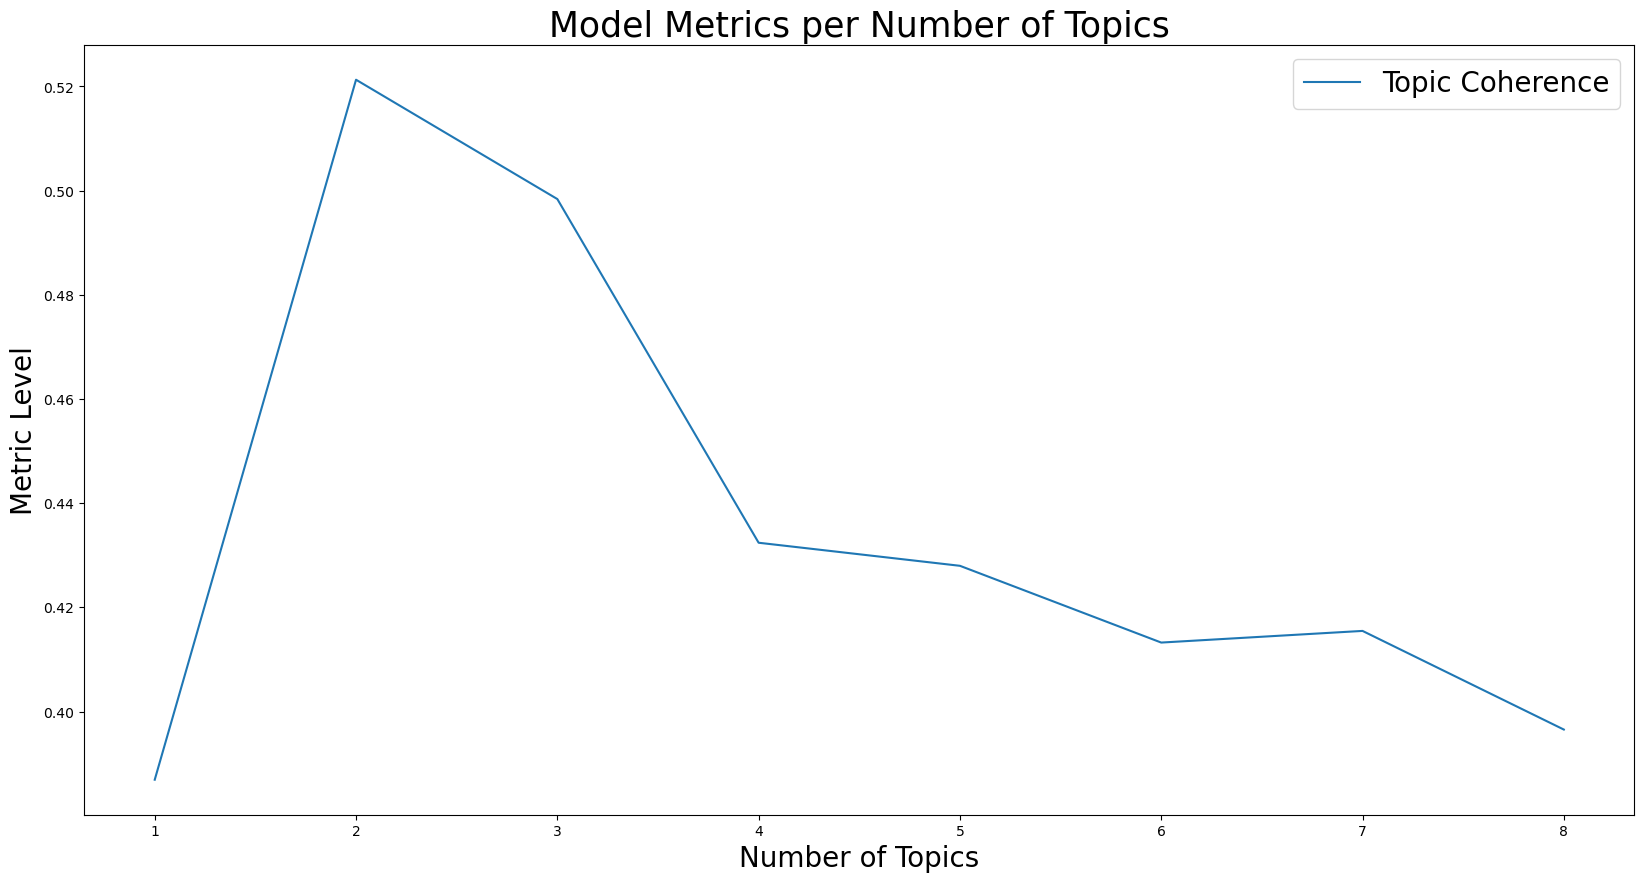

In [7]:
# Visualizing results
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics, y=coherences, label='Topic Coherence')
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [8]:
def format_topics_sentences(ldamodel, corpus, texts):
    sent_topics_df = pd.DataFrame()

    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            

        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [9]:
n_topics_pros = 2
lda_model_pros = LDA_models[n_topics_pros]

In [10]:
df_topic_pros_keywords = format_topics_sentences(ldamodel=lda_model_pros, corpus=corpus_pros, texts=data_ready_pros)

# Format
df_dominant_topic = df_topic_pros_keywords.reset_index()
df_dominant_topic.columns = ['Review_ID', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\U

In [11]:
df_dominant_topic['Review_ID'] = df['id']
df_dominant_topic.head(10)

Review_ID  Dominant_Topic  Topic_Perc_Contrib  \
0  empReview_73247758               1              0.8816   
1  empReview_73187609               0              0.9250   
2  empReview_73188818               0              0.8313   
3  empReview_73190433               0              0.6971   
4  empReview_73197210               0              0.9292   
5  empReview_73208298               1              0.7689   
6  empReview_73149307               1              0.8495   
7  empReview_73146117               0              0.7682   
8  empReview_73105526               0              0.9354   
9  empReview_73108472               0              0.7679   

                                            Keywords  \
0  opportunity, learn, amazon, lot, growth, work,...   
1  good, work, great, pay, benefit, time, job, en...   
2  good, work, great, pay, benefit, time, job, en...   
3  good, work, great, pay, benefit, time, job, en...   
4  good, work, great, pay, benefit, time, job, en...   
5  opportunity, learn, amazon, lot, growth, work,...   
6  opportunity, learn, amazon, lot, growth, work,...   
7  good, work, great, pay, benefit, time, job, en...   
8  good, work, great, pay, benefit, time, job, en...   
9  good, work, great, pay, benefit, time, job, en...   

                                                Text  
0  [documentation, amazon, super, important, poin...  
1                             [4, day, shifts, nice]  
2  [great, work, balance, great, environment, loc...  
3  [good, benefit, flexible, time, shift, take, c...  
4          [fast, paced, start-up, culture, benefit]  
5        [opportunity, grow, work, talented, people]  
6   [lot, challenge, speak, data, great, leadership]  
7                    [good, pay, benefit, new, grad]  
8                    [pay, rate, good, accord, work]  
9  [great, benefit, bonus, everything, available,...

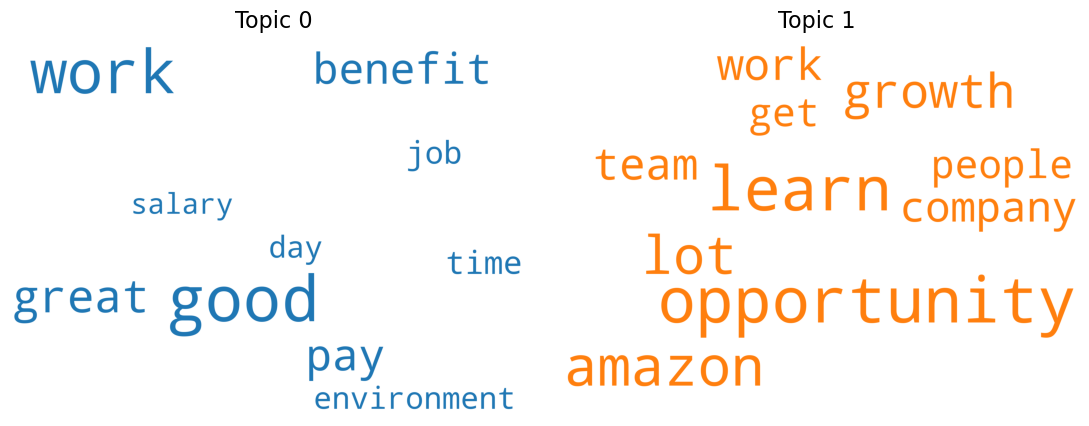

In [12]:
stop_words = set(stopwords.words('english'))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_pros.show_topics(formatted=False)

fig, axes = plt.subplots(1, 2, figsize=(11,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## Cons:

In [13]:
# Prepare Dictionary
data_ready_cons = df['Cons'].tolist()
id2word = corpora.Dictionary(data_ready_cons)
corpus_cons = [id2word.doc2bow(text) for text in data_ready_cons]

In [14]:
# Building model
num_topics = [i+1 for i in range(8)]
num_keywords = 20

LDA_models = {}
LDA_topics = {}
for i in tqdm(num_topics):
    LDA_models[i] = gensim.models.ldamodel.LdaModel(corpus=corpus_cons,
                                                    id2word=id2word,
                                                    num_topics=i,
                                                    update_every=1,
                                                    chunksize=10,
                                                    passes=20,
                                                    alpha='asymmetric',
                                                    random_state=100)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

100%|██████████| 8/8 [07:25<00:00, 55.71s/it]


In [15]:
coherences = []
for i in tqdm(num_topics):
    coherences.append(gensim.models.CoherenceModel(model=LDA_models[i], texts=data_ready_cons, dictionary=id2word, coherence='c_v').get_coherence())

100%|██████████| 8/8 [00:55<00:00,  6.98s/it]


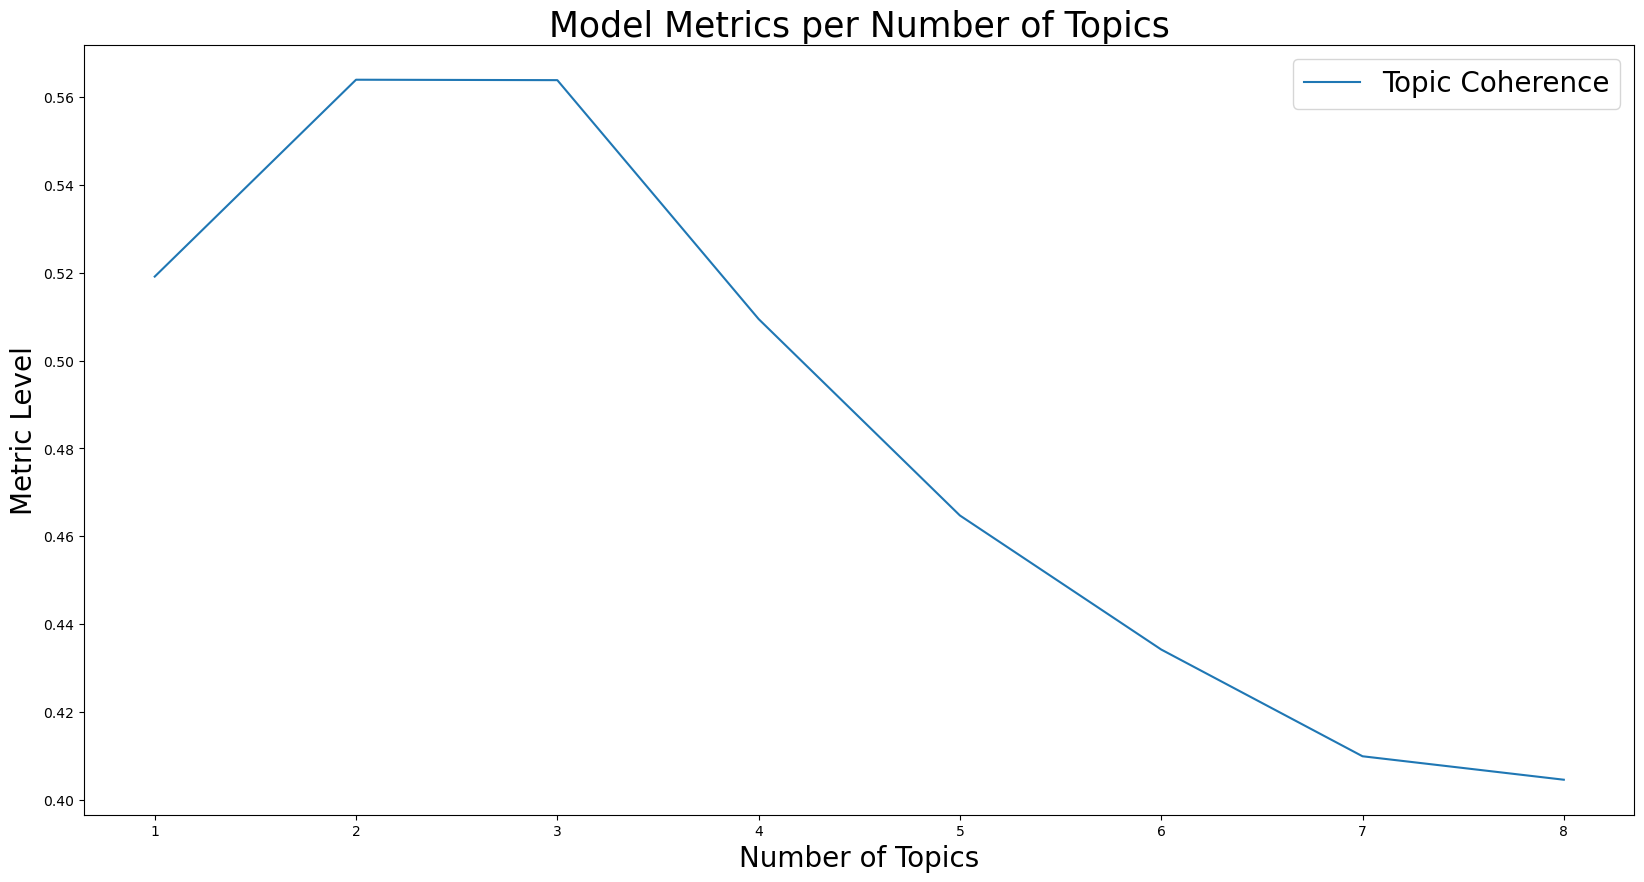

In [16]:
# Visualizing results
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics, y=coherences, label='Topic Coherence')
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [17]:
n_topics_cons = 3
lda_model_cons = LDA_models[n_topics_cons]

In [18]:
df_topic_cons_keywords = format_topics_sentences(ldamodel=lda_model_cons, corpus=corpus_cons, texts=data_ready_cons)

# Format
df_dominant_topic_cons = df_topic_cons_keywords.reset_index()
df_dominant_topic_cons.columns = ['Review_ID', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\2700792715.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
C:\U

In [19]:
df_dominant_topic_cons['Review_ID'] = df['id']
df_dominant_topic_cons.head(10)

Review_ID  Dominant_Topic  Topic_Perc_Contrib  \
0  empReview_73247758               2              0.6531   
1  empReview_73187609               0              0.6398   
2  empReview_73188818               0              0.8691   
3  empReview_73190433               1              0.4363   
4  empReview_73197210               1              0.8771   
5  empReview_73208298               0              0.5003   
6  empReview_73149307               1              0.4012   
7  empReview_73146117               0              0.8953   
8  empReview_73105526               0              0.4953   
9  empReview_73108472               0              0.5332   

                                            Keywords  \
0  n't, con, job, manager, amazon, employee, like...   
1  work, hour, time, long, lot, day, shift, much,...   
2  work, hour, time, long, lot, day, shift, much,...   
3  get, bad, pay, balance, good, culture, life, t...   
4  get, bad, pay, balance, good, culture, life, t...   
5  work, hour, time, long, lot, day, shift, much,...   
6  get, bad, pay, balance, good, culture, life, t...   
7  work, hour, time, long, lot, day, shift, much,...   
8  work, hour, time, long, lot, day, shift, much,...   
9  work, hour, time, long, lot, day, shift, much,...   

                                                Text  
0  [need, understand, job, need, improve, good, d...  
1              [long, hour, shift, make, feel, tire]  
2                       [workload, heavy, sometimes]  
3  [good, organization, work, well, car, parking,...  
4  [compensation, growth, prospect, development, ...  
5                    [potential, layoff, fast, pace]  
6          [none, best, company, ever, glad, worked]  
7                          [lot, work, high, stress]  
8                     [much, stress, give, employee]  
9  [work, culture, negative, depend, location, li...

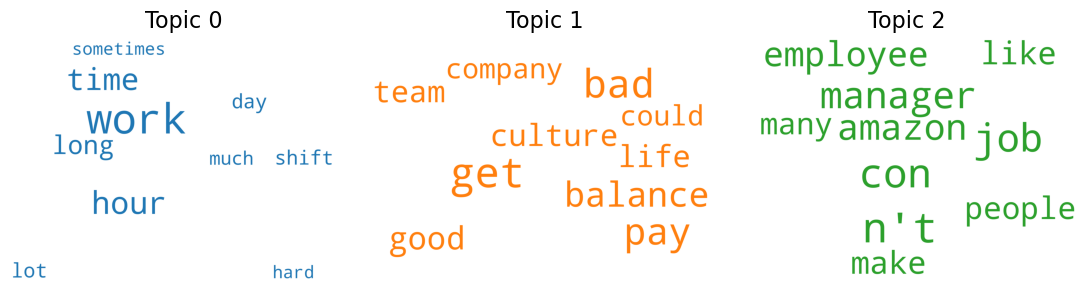

In [20]:
stop_words = set(stopwords.words('english'))
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model_cons.show_topics(formatted=False)

fig, axes = plt.subplots(1, 3, figsize=(11,11), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

# Data Export:

In [21]:
df_pros_cons = df[["id", "current_employee"]]

df_pros_cons["Pros_Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]
df_pros_cons["Pros_Topic_Perc_Contrib"] = df_dominant_topic["Topic_Perc_Contrib"]
df_pros_cons["Pros_Keywords"] = df_dominant_topic["Keywords"]

df_pros_cons["Cons_Dominant_Topic"] = df_dominant_topic_cons["Dominant_Topic"]
df_pros_cons["Cons_Topic_Perc_Contrib"] = df_dominant_topic_cons["Topic_Perc_Contrib"]
df_pros_cons["Cons_Keywords"] = df_dominant_topic_cons["Keywords"]

df_pros_cons

C:\Users\Konstantin\AppData\Local\Temp\ipykernel_12448\977120469.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pros_cons["Pros_Dominant_Topic"] = df_dominant_topic["Dominant_Topic"]


id  current_employee  Pros_Dominant_Topic  \
0     empReview_73247758  current employee                    1   
1     empReview_73187609   former employee                    0   
2     empReview_73188818   former employee                    0   
3     empReview_73190433   former employee                    0   
4     empReview_73197210  current employee                    0   
...                  ...               ...                  ...   
9995  empReview_71536795  current employee                    1   
9996  empReview_71537065  current employee                    1   
9997  empReview_71539933  current employee                    0   
9998  empReview_71882994   former employee                    1   
9999  empReview_72354621   former employee                    1   

      Pros_Topic_Perc_Contrib  \
0                      0.8816   
1                      0.9250   
2                      0.8313   
3                      0.6971   
4                      0.9292   
...                       ...   
9995                   0.6897   
9996                   0.6065   
9997                   0.9658   
9998                   0.9774   
9999                   0.7427   

                                          Pros_Keywords  Cons_Dominant_Topic  \
0     opportunity, learn, amazon, lot, growth, work,...                    2   
1     good, work, great, pay, benefit, time, job, en...                    0   
2     good, work, great, pay, benefit, time, job, en...                    0   
3     good, work, great, pay, benefit, time, job, en...                    1   
4     good, work, great, pay, benefit, time, job, en...                    1   
...                                                 ...                  ...   
9995  opportunity, learn, amazon, lot, growth, work,...                    1   
9996  opportunity, learn, amazon, lot, growth, work,...                    1   
9997  good, work, great, pay, benefit, time, job, en...                    0   
9998  opportunity, learn, amazon, lot, growth, work,...                    1   
9999  opportunity, learn, amazon, lot, growth, work,...                    1   

      Cons_Topic_Perc_Contrib  \
0                      0.6531   
1                      0.6398   
2                      0.8691   
3                      0.4363   
4                      0.8771   
...                       ...   
9995                   0.4662   
9996                   0.8251   
9997                   0.6148   
9998                   0.4160   
9999                   0.6606   

                                          Cons_Keywords  
0     n't, con, job, manager, amazon, employee, like...  
1     work, hour, time, long, lot, day, shift, much,...  
2     work, hour, time, long, lot, day, shift, much,...  
3     get, bad, pay, balance, good, culture, life, t...  
4     get, bad, pay, balance, good, culture, life, t...  
...                                                 ...  
9995  get, bad, pay, balance, good, culture, life, t...  
9996  get, bad, pay, balance, good, culture, life, t...  
9997  work, hour, time, long, lot, day, shift, much,...  
9998  get, bad, pay, balance, good, culture, life, t...  
9999  get, bad, pay, balance, good, culture, life, t...  

[10000 rows x 8 columns]

In [22]:
df_pros_cons.to_csv(f'data/Amazon/employee_pros_cons_topic_modelling.csv', index=False)